In [4]:
import os
import numpy as np
from tqdm import tqdm
import random
import json
import pickle

from mne.channels import make_standard_montage
from mne.io import read_raw_edf
from mne.datasets import eegbci
from mne import events_from_annotations, Epochs, pick_types
from mne.decoding import Scaler

from sklearn.model_selection import train_test_split
from params import PARAMS
from train import get_dataloaders


In [5]:
def generate_preprocessed_data(subject_idc):
    """
    4, 8, 12: Motor imagery: T1: left vs T2: right hand
    6, 10, 14: Motor imagery: T1: hands vs T2: feet

    label map:
    0: left hand
    1: right hand
    2: fist both hands
    3: feet
    """

    dataset_path = 'dataset/physionet.org/files/eegmmidb/1.0.0/'

    run_idc = [4, 6, 8, 10, 12, 14]  # motor imagery: hands vs feet

    delta = 1. / 160.

    whole_data = []
    whole_label = []
    for subject_idx in subject_idc:
        subject_data = []
        subject_label = []
        for run_idx in run_idc:
            fname = os.path.join(dataset_path, f"S{subject_idx:03d}", f"S{subject_idx:03d}R{run_idx:02d}.edf")
            raw = read_raw_edf(fname, preload=True, verbose=False)
            eegbci.standardize(raw)  # set channel names
            montage = make_standard_montage('standard_1005')
            raw.set_montage(montage)

            # strip channel names of "." characters
            raw.rename_channels(lambda x: x.strip('.'))

            if run_idx in [4, 8, 12]:
                events, event_id = events_from_annotations(raw, event_id=dict(T1=0, T2=1), verbose=False)
            elif run_idx in [6, 10, 14]:
                events, event_id = events_from_annotations(raw, event_id=dict(T1=2, T2=3), verbose=False)

            picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False, exclude='bads')

            epochs = Epochs(raw, events, event_id=event_id, tmin=0, tmax=100/160 - delta, baseline=None, preload=True, proj=False, picks=picks, verbose=False)
            
            data = epochs.get_data()
            label = epochs.events[:, -1]

            subject_data.append(data)
            subject_label.append(label)

        subject_data = np.vstack(subject_data)
        subject_label = np.hstack(subject_label)
        
        whole_data.append(subject_data)
        whole_label.append(subject_label)

    whole_data = np.vstack(whole_data).astype(np.float32)
    whole_label = np.hstack(whole_label)


    scaler = Scaler(scalings='mean')
    whole_data = scaler.fit_transform(whole_data)
    
    return whole_data, whole_label

In [6]:
def split_subjects(n_splits):
    subject_idc = [i for i in range(1, 110)]
    exclusions = [88, 89, 92, 100]
    subject_idc = [i for i in subject_idc if i not in exclusions]

    for i in tqdm(range(n_splits)):
        test_idc = random.sample(subject_idc, 10)
        train_idc = [i for i in subject_idc if i not in test_idc]

        idc_dict = {'train_idc': train_idc, 'test_idc': test_idc}
        json.dump(idc_dict, open(f"./dataset/train/cross_subject_data_{i}.json", "w"))

        X_train, y_train = generate_preprocessed_data(train_idc)
        X_test, y_test = generate_preprocessed_data(test_idc)

        cross_subject_data = {"X_train": X_train, "y_train": y_train, "X_test": X_test, "y_test": y_test}

        pickle.dump(cross_subject_data, open(f"./dataset/train/cross_subject_data_{i}_mne.pickle", "wb"))


split_subjects(n_splits=1)

def split_samples(n_splits):
    subject_idc = [i for i in range(1, 110)]
    exclusions = [88, 89, 92, 100]
    subject_idc = [i for i in subject_idc if i not in exclusions]

    X, y = generate_preprocessed_data(subject_idc)
    
    for i in tqdm(range(n_splits)):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=PARAMS['TEST_SIZE'], shuffle=True, random_state=PARAMS['RANDOM_SEEDS'][i])

        cross_subject_data = {"X_train": X_train, "y_train": y_train, "X_test": X_test, "y_test": y_test}

        pickle.dump(cross_subject_data, open(f"./dataset/train/cross_subject_data_{i}_mne.pickle", "wb"))


split_samples(n_splits=1)

100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


In [17]:
dataset = pickle.load(open('dataset/train/cross_subject_data_0_new_20_subjects.pickle', 'rb'))

In [18]:
dataset.keys()

dict_keys(['X_train', 'y_train', 'X_test', 'y_test'])

In [19]:
random_seed = 0
X_train, X_test, y_train, y_test = dataset['X_train'], dataset['X_test'], dataset['y_train'], dataset['y_test'] 
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=PARAMS['VALID_SIZE'], shuffle=True, random_state=random_seed)
print('Data sizes:')
print('Train sizes:')
print(X_train.shape)
print(y_train.shape)
print('Valid sizes:')
print(X_valid.shape)
print(y_valid.shape)
print('Test sizes:')
print(X_test.shape)
print(y_test.shape)

dataloaders = get_dataloaders(X_train, y_train, X_valid, y_valid, X_test, y_test, PARAMS['BATCH_SIZE'], random_seed=random_seed, device=PARAMS['DEVICE'])

Data sizes:
Train sizes:
(1440, 64, 100)
(1440,)
Valid sizes:
(180, 64, 100)
(180,)
Test sizes:
(180, 64, 100)
(180,)


In [21]:
from models import GCNAuto
from main import init_model_params
import torch
from train import train_model_2

RANDOM_SEED = random_seed
N_EPOCHS = 300


model = GCNAuto(kernel_type='a',
        in_features=PARAMS['SEQ_LEN'], 
        n_nodes=PARAMS['N_CHANNELS'], 
        num_classes=PARAMS['N_CLASSES'], 
        hidden_sizes=PARAMS['GCNAUTO_HIDDEN_SIZES'], 
        dropout_p=0.5, 
        device=PARAMS['DEVICE'])

model = init_model_params(model, random_seed=RANDOM_SEED)
model.init_node_embeddings()

model = model.to(PARAMS['DEVICE'])

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=PARAMS['LR'])
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)

# best_model, history = train_model(dataloaders, dataset_sizes, model, criterion, optimizer, scheduler, PARAMS['N_EPOCHS'], random_seed=random_seed)
best_model, history = train_model_2(model, optimizer, scheduler, criterion, dataloaders['train'], dataloaders['val'], N_EPOCHS, RANDOM_SEED, PARAMS['DEVICE'], verbose=True)
best_model = best_model.to(PARAMS['DEVICE'])

train() called: model=GCNAuto, opt=Adam(lr=0.001000), epochs=300, device=cuda

Epoch   1/300, LR: 0.0010, train loss: 4.6917, train acc: 0.2632, val loss: 1.2218, val acc: 0.3187
Epoch  10/300, LR: 0.0010, train loss: 1.1362, train acc: 0.5062, val loss: 1.0039, val acc: 0.4437
Epoch  20/300, LR: 0.0009, train loss: 1.0128, train acc: 0.5771, val loss: 1.1737, val acc: 0.5000
Epoch  30/300, LR: 0.0008, train loss: 0.8934, train acc: 0.6208, val loss: 1.1665, val acc: 0.5188
Epoch  40/300, LR: 0.0007, train loss: 0.7353, train acc: 0.6944, val loss: 1.6555, val acc: 0.5000
Epoch  50/300, LR: 0.0007, train loss: 0.5832, train acc: 0.7632, val loss: 2.0356, val acc: 0.4750
Epoch  60/300, LR: 0.0006, train loss: 0.5074, train acc: 0.8035, val loss: 2.0652, val acc: 0.5000
Epoch  70/300, LR: 0.0005, train loss: 0.4352, train acc: 0.8410, val loss: 2.7501, val acc: 0.5000
Epoch  80/300, LR: 0.0005, train loss: 0.3563, train acc: 0.8611, val loss: 2.5703, val acc: 0.5437
Epoch  90/300, LR: 0.

In [24]:
adj = best_model.adj.cpu().detach().numpy()

<AxesSubplot:>

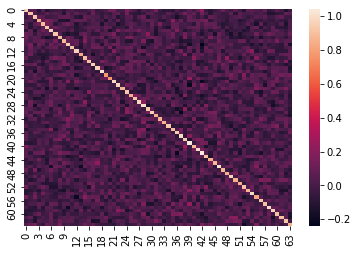

In [25]:
import seaborn as sns
sns.heatmap(adj)

In [26]:
from main import model_predict, print_classification_report

y_preds, y_test = model_predict(best_model, test_loader=dataloaders['test'])

cr, cm, auroc = print_classification_report(y_test, y_preds, PARAMS['N_CLASSES'])

In [27]:
print(cr)

{'0': {'precision': 0.4722222222222222, 'recall': 0.4857142857142857, 'f1-score': 0.47887323943661975, 'support': 35}, '1': {'precision': 0.4186046511627907, 'recall': 0.5142857142857142, 'f1-score': 0.4615384615384615, 'support': 35}, '2': {'precision': 0.3055555555555556, 'recall': 0.275, 'f1-score': 0.2894736842105263, 'support': 40}, '3': {'precision': 0.4222222222222222, 'recall': 0.38, 'f1-score': 0.4, 'support': 50}, 'accuracy': 0.40625, 'macro avg': {'precision': 0.4046511627906977, 'recall': 0.41374999999999995, 'f1-score': 0.4074713462964019, 'support': 160}, 'weighted avg': {'precision': 0.4032017118863049, 'recall': 0.40625, 'f1-score': 0.4030834806409306, 'support': 160}}


In [28]:
print(auroc)

0.6072878787878787


<AxesSubplot:>

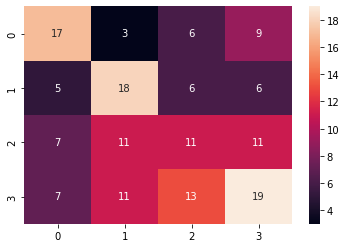

In [29]:
sns.heatmap(cm, annot=True, fmt='g')